# Bike-sharing with Pytorch implementation
In this notebook, there is going to be an implementation in PyTorch. I want to see how the results
will differ with both momentum and dropout.

In [45]:
# import the necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from sklearn.utils import shuffle
from torch.autograd import Variable

# set the default style 
sns.set()

In [5]:
# load and visualize the data
data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)
rides.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and wind speed, all of these likely affecting the number of riders.

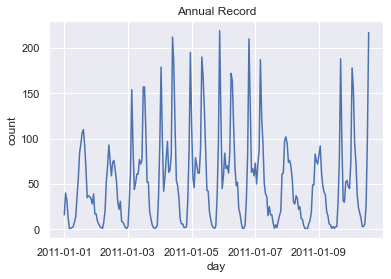

In [6]:
rides[:24*10].plot(x='dteday', y='cnt', title='Annual Record',
                   xlabel='day', ylabel='count', legend=False)
plt.show()

### Dummy encoding
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [49]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved, so we can go backwards when we use the network for predictions.

In [50]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

c:\users\dinar\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### Additional test set
In this notebook, we are working with the entries from two years, and we want to predict on the last month of the second year - December. Thus, let's get the values for that month.

In [91]:
# get the hold-out set for the final results 
last_month = data[-21*24:]
december_test_X = last_month.drop('cnt', axis=1)
december_test_y = last_month['cnt']

# sanity check
print(f'X shape: {december_test_X.shape} & y shape: {december_test_y.shape}')

X shape: (504, 109) & y shape: (504,)


### Splitting the datasets into three categories: train, validation, and test
In order to get good results, we need to ensure that the output can be generalized well. To do so, I will break the dataset
into three categories with train set being 70%, validation and test sets being 15% each.

In [92]:
# split data into three categories 
data = data[:-21*24]
X, y = data.drop('cnt', axis=1), data['cnt']
X_train, X_remain, y_train, y_remain = train_test_split(X, y, test_size=0.3, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_train, y_train, test_size=0.5, shuffle=True)
print(f'X_train shape: {X_train.shape} & y_train shape: {y_train.shape}\n'
      f'X_validation:  {X_valid.shape} & y_validation:  {y_valid.shape}\n'
      f'X_test shape:  {X_test.shape} & y_test shape:  {y_test.shape}')

X_train shape: (10048, 109) & y_train shape: (10048,)
X_validation:  (5024, 109) & y_validation:  (5024,)
X_test shape:  (5024, 109) & y_test shape:  (5024,)


### Building the architecture


In [96]:
class Network(nn.Module):
    def __init__(self, n_feature, n_hidden, n_hidden2, n_output):
        super().__init__()
        # inputs to hidden layer transformation
        self.hidden = nn.Linear(n_feature, n_hidden)
        # hidden to hidden
        self.hidden2 = nn.Linear(n_hidden, n_hidden2)
        # hidden to hidden layer
        self.output = nn.Linear(n_hidden2, n_output)
        # dropout
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = F.relu(self.hidden2(x))
        x = self.output(x)
        return x
        

In [97]:
features = X_train.shape[1]
hidden = 100
hidden2 = 50
output = 1
learning_rate = 0.03

model = Network(features, hidden, hidden2, output)
model

Network(
  (hidden): Linear(in_features=109, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [98]:
# instantiate the optimizer and loss function
optimizer = SGD(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss(reduction='sum')

In [99]:
to_numpy = lambda x: torch.Tensor(list(x.values))
X_train = torch.Tensor(list(X_train.values))
X_test = torch.Tensor(list(X_test.values))
X_valid = torch.Tensor(list(X_valid.values))
y_train = torch.Tensor(list(y_train.values))
y_test = torch.Tensor(list(y_test.values))
y_valid = torch.Tensor(list(y_valid.values))
december_test_X = torch.Tensor(list(december_test_X.values))
december_test_y = torch.Tensor(list(december_test_y.values))

# sanity check
print(type(X_valid))

TypeError: 'builtin_function_or_method' object is not iterable

In [104]:
test_loss = 0.0

# create a holder for smallest error to save the model
validation_min_loss = np.Inf

n_epochs = 30
batch_size = 50
batch_number = len(X_train) // batch_size  #batches

for epoch in range(1, n_epochs):
    X_train, y_train = shuffle(X_train, y_train)
    # instantiate losses to keep track of
    train_loss = 0.0
    validation_loss = 0.0
    
    model.train()
    # mini batch learning
    for i in range(1, batch_number):
        start = i * batch_size
        end = start + batch_size
        inputs = X_train[start:end]
        labels = y_train[start:end]
        
        # zero grad
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, torch.unsqueeze(labels,dim=1))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    model.eval()
    for i in range(batch_number):
        start = i * batch_size
        end = start + batch_size
        inputs = X_valid[start:end]
        labels = y_valid[start:end]
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        validation_loss += loss.item()
    
    # calculate average loss
    train_loss /= len(X_train)
    validation_loss /= len(X_valid)
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, validation_loss))
    
    if validation_loss <= validation_min_loss:
        print(f'Validation loss decreased from {round(validation_min_loss, 5)} to {round(validation_loss, 5)}\nSaving the model')
        torch.save(model.state_dict(), 'bike_sharing.pt')
        validation_min_loss = validation_loss    
        

c:\users\dinar\appdata\local\programs\python\python38\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\dinar\appdata\local\programs\python\python38\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\dinar\appdata\local\programs\python\python38\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([0])) that is different to the input size (torch.Size([0, 1])). This will likely lead to incorrect 

Epoch: 1 	Training Loss: nan 	Validation Loss: nan
Epoch: 2 	Training Loss: nan 	Validation Loss: nan
Epoch: 3 	Training Loss: nan 	Validation Loss: nan
Epoch: 4 	Training Loss: nan 	Validation Loss: nan
Epoch: 5 	Training Loss: nan 	Validation Loss: nan
Epoch: 6 	Training Loss: nan 	Validation Loss: nan
Epoch: 7 	Training Loss: nan 	Validation Loss: nan
Epoch: 8 	Training Loss: nan 	Validation Loss: nan
Epoch: 9 	Training Loss: nan 	Validation Loss: nan
Epoch: 10 	Training Loss: nan 	Validation Loss: nan
Epoch: 11 	Training Loss: nan 	Validation Loss: nan
Epoch: 12 	Training Loss: nan 	Validation Loss: nan
Epoch: 13 	Training Loss: nan 	Validation Loss: nan
Epoch: 14 	Training Loss: nan 	Validation Loss: nan
Epoch: 15 	Training Loss: nan 	Validation Loss: nan
Epoch: 16 	Training Loss: nan 	Validation Loss: nan
Epoch: 17 	Training Loss: nan 	Validation Loss: nan
Epoch: 18 	Training Loss: nan 	Validation Loss: nan
Epoch: 19 	Training Loss: nan 	Validation Loss: nan
Epoch: 20 	Training L